In [1]:
!pip install adversarial-robustness-toolbox git+https://github.com/pesser/pytorch_diffusion.git -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 80.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.0 MB/s eta 0:00:00:00:0100:01


Using device: cpu


100%|██████████| 170M/170M [00:05<00:00, 29.4MB/s] 


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023529414..1.0235294].


Adversarial accuracy (no defense): 23.44%
Accuracy after UNet purification: 90.62%


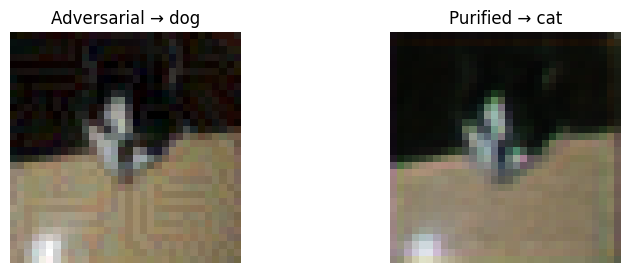

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
N_ADV_SAMPLES = 1000

CLASSES = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

print("Using device:", DEVICE)

CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465]).view(1,3,1,1).to(DEVICE)
CIFAR_STD  = torch.tensor([0.2023, 0.1994, 0.2010]).view(1,3,1,1).to(DEVICE)

def normalize_cifar10(x):
    return (x - CIFAR_MEAN) / CIFAR_STD
    
transform = transforms.ToTensor()

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

def make_resnet18_cifar10():
    model = torchvision.models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

classifier = make_resnet18_cifar10().to(DEVICE)
classifier.load_state_dict(
    torch.load("/kaggle/input/baseline-model/pytorch/default/1/temp_baseline_resnet_cifar.pth", map_location=DEVICE)
)
classifier.eval()

criterion = nn.CrossEntropyLoss()

art_classifier = PyTorchClassifier(
    model=classifier,
    loss=criterion,
    optimizer=None,
    input_shape=(3,32,32),
    nb_classes=10,
    device_type=DEVICE.type
)

pgd_attack = ProjectedGradientDescent(
    estimator=art_classifier,
    eps=8/255,
    eps_step=2/255,
    max_iter=10,
    batch_size=BATCH_SIZE
)

class PurifierUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        b = self.bottleneck(p2)

        d2 = self.up2(b)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        return self.dec1(torch.cat([d1, e1], dim=1))

purifier = PurifierUNet().to(DEVICE)
purifier.load_state_dict(
    torch.load("/kaggle/input/unet-purification-model/pytorch/default/1/purifier_unet_cifar10.pth", map_location=DEVICE)
)
purifier.eval()

x_clean, y = next(iter(test_loader))
x_clean = x_clean[:N_ADV_SAMPLES].to(DEVICE)
y = y[:N_ADV_SAMPLES].to(DEVICE)

x_adv = pgd_attack.generate(x_clean.cpu().numpy())
x_adv = torch.tensor(x_adv).to(DEVICE)


with torch.no_grad():
    logits_adv = classifier(normalize_cifar10(x_adv))
    acc_adv = (logits_adv.argmax(1) == y).float().mean().item() * 100

    x_pur = purifier(x_adv)
    logits_pur = classifier(normalize_cifar10(x_pur))
    acc_pur = (logits_pur.argmax(1) == y).float().mean().item() * 100

print(f"Adversarial accuracy (no defense): {acc_adv:.2f}%")
print(f"Accuracy after UNet purification: {acc_pur:.2f}%")

idx = random.randint(0, logits_adv.size(0) - 1)

with torch.no_grad():
    pred_adv = logits_adv[idx].argmax().item()
    pred_pur = logits_pur[idx].argmax().item()

plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
plt.imshow(x_adv[idx].permute(1,2,0).cpu())
plt.title(f"Adversarial → {CLASSES[pred_adv]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(x_pur[idx].permute(1,2,0).cpu())
plt.title(f"Purified → {CLASSES[pred_pur]}")
plt.axis("off")

plt.show()

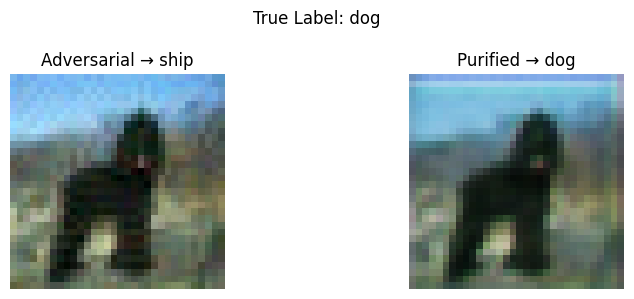

In [14]:
idx = random.randint(0, x_adv.size(0) - 1)

adv_img = x_adv[idx:idx+1]
pur_img = x_pur[idx:idx+1]
true_label = y[idx].item()

with torch.no_grad():
    pred_adv = logits_adv[idx].argmax().item()
    pred_pur = logits_pur[idx].argmax().item()

adv_vis = torch.clamp(adv_img.squeeze(), 0, 1)
pur_vis = torch.clamp(pur_img.squeeze(), 0, 1)

plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.imshow(adv_vis.permute(1, 2, 0).cpu().numpy())
plt.title(f"Adversarial → {CLASSES[pred_adv]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pur_vis.permute(1, 2, 0).cpu().numpy())
plt.title(f"Purified → {CLASSES[pred_pur]}")
plt.axis("off")

plt.suptitle(f"True Label: {CLASSES[true_label]}")
plt.tight_layout()
plt.show()